In [1]:
import pandas as pd
import numpy as np
import datetime as  dt
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

In [2]:
s = yf.Ticker("SPAL.NS")
dff =  s.history(start="2020-01-01",  end="2021-10-01",interval='1d')
dff.drop(['Dividends'],axis=1,inplace=True)
dff.drop(['Stock Splits'],axis=1,inplace=True)
df= dff.copy()
for i in range(df.shape[0]):
  if i > 0:
    df.loc[df.index[i],'Open'] = (dff['Open'][i-1] + dff['Close'][i-1])/2
  
  df.loc[df.index[i],'Close'] = (dff['Open'][i] + dff['Close'][i] + dff['Low'][i] +  dff['High'][i])/4
df = df.iloc[1:,:]

df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2020-01-02,202.216369,205.024930,202.019275,203.066330,18682
2020-01-03,202.610557,205.517663,203.546743,204.556837,49863
2020-01-06,204.581471,208.079863,201.970015,204.359754,27638
2020-01-07,203.694570,214.386813,204.335125,208.868239,24609
2020-01-08,208.375509,218.673554,206.995863,213.204256,18232


In [3]:
def RSI(Df,n):
    
    df = Df.copy()
    delta = df['Close'].diff(1)
    delta.dropna(inplace=True)
    pos=delta.copy()
    neg=delta.copy()
    pos[pos<0]=0
    neg[neg>0]=0
    avg_gain=pos.rolling(window=n).mean()
    avg_loss=abs(neg.rolling(window=n).mean())
    RS=avg_gain/avg_loss
    
   
    RSI = 100 - (100 / (1 + RS))
    df['RSI']=RSI
    
    return df

In [4]:
OBV=[]
OBV.append(0)
for i in range(1,len(df.Close)):
    if df.Close[i]>df.Close[i-1]:
        OBV.append(OBV[-1]+df.Volume[i])
    elif df.Close[i]<df.Close[i-1]:
        OBV.append(OBV[-1]-df.Volume[i])
    else:
          
        OBV.append(OBV[-1])
        

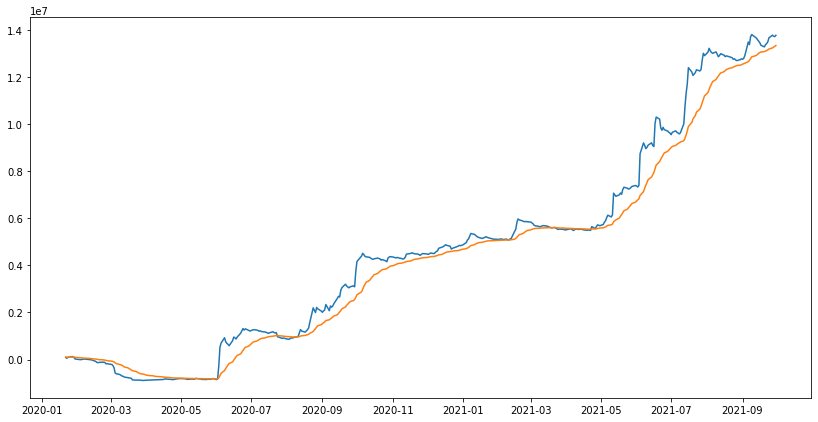

In [5]:
df['OBV']=OBV
df['OBV_EMA']=df['OBV'].ewm(span=26).mean()
df['EMA10'] = df['Close'].ewm(span=10).mean()
df['EMA13'] = df['Close'].ewm(span=13).mean()
df['EMA26'] = df['Close'].ewm(span=26).mean()
df['RSI'] = RSI(df, 14)['RSI']
df.dropna(inplace=True)
df.head()
plt.figure(figsize = (14, 7))
plt.plot(df['OBV'],label='obv')
plt.plot(df['OBV_EMA'],label='obvema')

,Open,High,Low,Close,Volume,OBV,OBV_EMA,EMA10,EMA13,EMA26,RSI,Position,Cash,Shares
Date,,,,,,,,,,,,,,
2020-01-22,211.553610,210.740606,193.741422,201.637417,26372,88243,107753.135607,216.247203,216.505674,216.391003,48.539047,Sell,1000,0
2020-01-23,201.033820,201.723651,195.121072,197.757177,31562,56681,102410.570675,212.744111,213.578863,214.441751,43.371770,Sell,0,0
2020-01-24,197.091992,212.612979,197.436902,205.074213,37096,93777,101534.187856,211.302002,212.268574,213.490864,50.611556,Sell,0,0
2020-01-27,205.123485,215.175180,205.468394,211.073197,21839,115616,102925.446069,211.259247,212.086447,213.252003,51.840421,Sell,0,0
2020-01-28,211.824607,216.259190,209.410246,212.576037,10901,126517,105200.013235,211.504071,212.160339,213.186830,49.449611,Sell,0,0


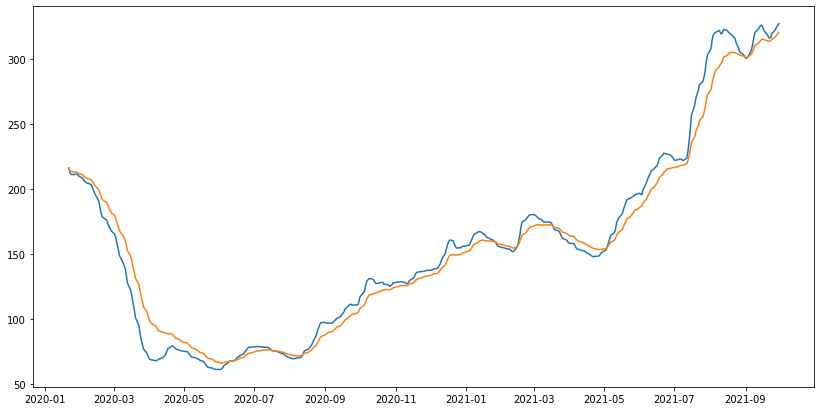

In [6]:


df.loc[(df['OBV']>df['OBV_EMA'])&(df['EMA10']>df['EMA26'])&(df['RSI']>30),'Position']='Buy'
df.loc[(df['OBV']<df['OBV_EMA'])|(df['EMA26']>df['EMA10'])|(df['RSI']<30),'Position']='Sell'
df.dropna(inplace=True)
df['Cash']=0
df['Shares']=0
df.iloc[0, 12] = 1000
df.head()
plt.figure(figsize = (14, 7))
plt.plot(df['EMA10'],label='EMA10')
plt.plot(df['EMA26'],label='EMA26')
df.head()

In [7]:
for i in range(len(df)):
    clp = df.iloc[i, 3]
    cas = df.iloc[i, 12]
    shr = df.iloc[i, 13]
    cash = cas
    shares = 0
    if 'Buy' in df['Position'].iloc[i]:
    
            if (cas > 3*clp):
                shares = 3
                cash = cas - 3*clp
            elif (cash > 2*clp):
                shares = 2
                cash = cas - 2*clp
            elif (cash > clp):
                shares = 1
                cash = cas - clp
            else:
                shares = 0
                cash = cas
    if 'Sell' in df['Position'].iloc[i]:
            if (shr >= 3):
                shares = -3
                cash = cas + 3*clp
            elif (shr >= 2):
                shares = -2
                cash = cas + 2*clp
            elif (shr >= 1):
                shares = -1
                cash = cas + clp
            else:
                shares = 0
                cash = cas
        
    df.iloc[i, 12] = cash
    df.iloc[i, 13] = df.iloc[i, 13] + shares
    
    try:
        df.iloc[i + 1, 12] = df.iloc[i, 12]
        df.iloc[i + 1, 13] = df.iloc[i, 13]
    except:
        pass     
        
        
df.tail()

,Open,High,Low,Close,Volume,OBV,OBV_EMA,EMA10,EMA13,EMA26,RSI,Position,Cash,Shares
Date,,,,,,,,,,,,,,
2021-09-24,320.449997,343.799988,322.200012,332.437500,165299,13666438,1.319160e+07,319.962692,319.459501,315.782732,62.173206,Buy,159.927719,8
2021-09-27,331.875000,345.000000,324.000000,336.924995,111032,13777470,1.323499e+07,323.046747,321.954571,317.348825,53.284669,Buy,159.927719,8
2021-09-28,339.349991,342.000000,324.000000,334.125000,42456,13735014,1.327203e+07,325.060975,323.693204,318.591505,54.127030,Buy,159.927719,8
2021-09-29,335.250000,334.200012,322.549988,330.162498,16447,13718567,1.330511e+07,325.988525,324.617389,319.448615,44.531854,Buy,159.927719,8
2021-09-30,331.949997,342.000000,326.049988,334.837494,53924,13772491,1.333973e+07,327.597428,326.077404,320.588532,45.638698,Buy,159.927719,8


In [8]:
df['Net Worth'] = df['Cash'] + df['Shares'] * df['Close']


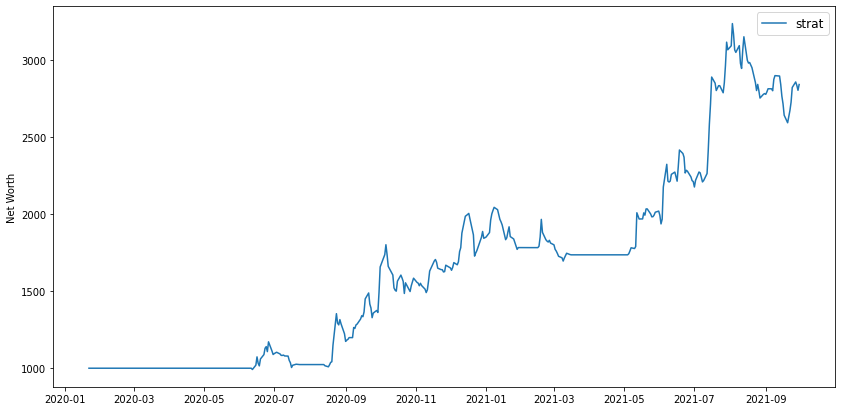

In [9]:
plt.figure(figsize = (14, 7))
plt.plot(df.index, df['Net Worth'], label = 'strat')
plt.legend(loc = 'upper right', fontsize = 12)
plt.ylabel('Net Worth')
plt.show()
   

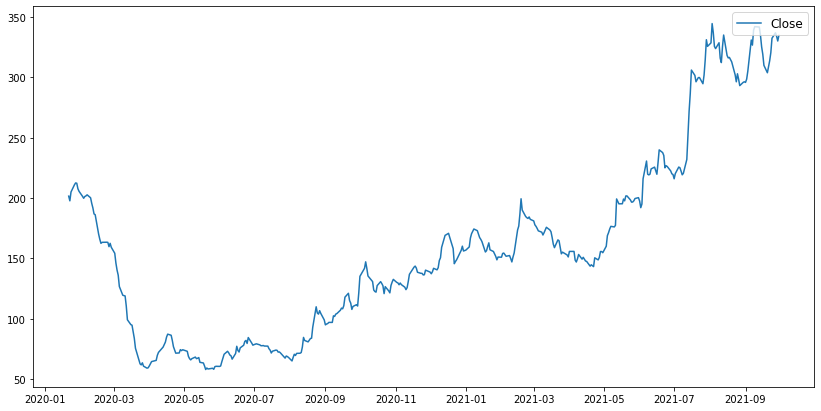

In [10]:
plt.figure(figsize = (14, 7))
plt.plot(df.index, df['Close'], label = 'Close')
plt.legend(loc = 'upper right', fontsize = 12)

In [11]:
import ffn
p=ffn.core.PerformanceStats(df['Close'])
p.display()

Stats for Close from 2020-01-22 00:00:00 - 2021-09-30 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
66.06%              0.82  35.02%  -72.70%

Annualized Returns:
mtd     3m      6m       ytd      1y       3y    5y    10y    incep.
------  ------  -------  -------  -------  ----  ----  -----  --------
12.98%  52.51%  118.91%  113.93%  175.82%  -     -     -      35.02%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  0.82     0.84       -
mean    45.73%   75.62%     113.93%
vol     55.61%   89.76%     -
skew    0.67     -0.73      -
kurt    2.81     1.36       -
best    18.35%   48.36%     113.93%
worst   -12.79%  -62.69%    113.93%

Drawdowns:
max      avg        # days
-------  -------  --------
-72.70%  -15.70%        85

Misc:
---------------  -------
avg. up month    20.94%
avg. down month  -20.88%
up year %        100.00%
12m up %  

In [12]:
q=ffn.core.PerformanceStats(df['Net Worth']) 
q.display()

Stats for Net Worth from 2020-01-22 00:00:00 - 2021-09-30 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
183.86%             1.79  85.45%  -19.88%

Annualized Returns:
mtd    3m      6m      ytd     1y      3y    5y    10y    incep.
-----  ------  ------  ------  ------  ----  ----  -----  --------
2.12%  28.45%  63.62%  53.80%  90.44%  -     -     -      85.45%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  1.79     1.80       -
mean    70.23%   70.66%     53.80%
vol     39.14%   39.20%     -
skew    1.90     1.41       -
kurt    9.64     2.45       -
best    17.81%   38.64%     53.80%
worst   -7.40%   -9.27%     53.80%

Drawdowns:
max      avg       # days
-------  ------  --------
-19.88%  -9.69%     30.57

Misc:
---------------  -------
avg. up month    12.79%
avg. down month  -2.55%
up year %        100.00%
12m up %         100.00%


In [13]:
#ABOUT STRATEGY
# It is a trend reversal strategy and hence works better on stocks which have a trend reversal in the given time frame
#compared to stocks which are only in an uptrend 
#In this strategy I have made use of a momentum indicator(RSI),trend indicator(EMA crossover),volume indicator(On-balanced Volume)
#Adding OBV gives us an idea about the market sentiment and volumes which goes well with the momentum and trend indicators

